### Importing Packages

In [118]:
import numpy as np
import pandas as pd
import string
import collections
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding
from keras.layers import LSTM
from keras.layers import GRU, Input, Dense, TimeDistributed
from keras.models import Model, Sequential
from keras.layers import Activation
from keras.optimizers import Adam
from keras.losses import sparse_categorical_crossentropy
import matplotlib.pyplot as plt

### Loading the Data - English and Tamil

In [54]:
with open('Data/English.txt','r',encoding="utf8") as file:
    english_data = file.readlines()
    file.close()

In [55]:
english_data = english_data[-1000:]

In [56]:
english_data[0] = english_data[0].strip('\ufeff')

In [57]:
with open('Data/Tamil.txt','r',encoding="utf8") as file:
    tamil_data = file.readlines()
    file.close()

In [58]:
tamil_data[0] = tamil_data[0].strip('\ufeff')

In [59]:
tamil_data = tamil_data[-1000:]

### Text Pre-Processing

In [60]:
exclude = set(string.punctuation)
for i in range(0,len(english_data)):
    english_data[i] = english_data[i].strip('\n')
    english_data[i] = ''.join(ch for ch in english_data[i] if ch not in exclude)

In [61]:
exclude = set(string.punctuation)
for i in range(0,len(tamil_data)):
    tamil_data[i] = tamil_data[i].strip('\n')
    tamil_data[i] = ''.join(ch for ch in tamil_data[i] if ch not in exclude)

In [62]:
len(english_data),len(tamil_data)

(1000, 1000)

In [63]:
print(f"English Text: {english_data[9]}\nTamil Text: {tamil_data[9]}")

English Text: Brown has insisted that this time round such a catastrophic devaluation would not occur due to careful economic management on his part and the greater flexibility of British workers his government had achieved  a reference to diminution of workers rights and lower wage rates in comparison with many western European countries
Tamil Text: தனது பங்கைப் பொறுத்தவரையில் பொருளாதார நிர்வாகம் அக்கறையுடன் கவனிக்கப்படுகிறது என்பதாலும் பிரிட்டிஷ் தொழிலாளர்களின் நெகிழ்வு தன்மையை அவர்களுடைய அரசாங்கம் சாதித்திருப்பதாலும் இந்தத் தடவை அவ்வாறு பேரழிவு நிலைக்கு பவுண்ட் மதிப்புக் குறைவு தோன்றாது என்று பிரெளன் வலியுறுத்தி இருக்கிறார்


In [64]:
english_words_list = []
for i in range(len(english_data)):
    english_words_list.append(english_data[i].split())

In [65]:
english_words_list = [j for sub in english_words_list for j in sub]

In [67]:
tamil_words_list = []
for i in range(0,len(tamil_data)):
    tamil_words_list.append(tamil_data[i].split())  

In [68]:
tamil_words_list = [j for sub in tamil_words_list for j in sub]

In [73]:
print(f"Number of Unique Tamil Words: {len(set(tamil_words_list))}\nNumber of Unique English Words: {len(set(english_words_list))}")

Number of Unique Tamil Words: 9413
Number of Unique English Words: 5858


In [74]:
tamilvocab = len(set(tamil_words_list))
engvocab = len(set(english_words_list))

In [77]:
english_words_counter = collections.Counter([word for sentence in english_data for word in sentence.split()])
tamil_words_counter = collections.Counter([word for sentence in tamil_data for word in sentence.split()])

### Most Common Words

In [78]:
english_words_counter.most_common(10)

[('the', 1765),
 ('of', 879),
 ('and', 747),
 ('to', 654),
 ('in', 529),
 ('a', 395),
 ('that', 284),
 ('is', 274),
 ('for', 201),
 ('The', 182)]

In [79]:
tamil_words_counter.most_common(10)

[('ஒரு', 165),
 ('மற்றும்', 143),
 ('என்று', 126),
 ('இந்த', 79),
 ('என்ற', 70),
 ('அவர்', 68),
 ('அவர்கள்', 53),
 ('அது', 52),
 ('என', 49),
 ('அரசியல்', 47)]

### Tokenizer and Padding

In [83]:
def tokenize(x):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(x) 
    return tokenizer.texts_to_sequences(x), tokenizer

In [95]:
##Sample
print(tokenize(tamil_data[99])[0])

[[9], [10], [1], [11], [7], [15], [9], [], [4], [14], [1], [14], [8], [13], [1], [13], [3], [9], [1], [], [9], [13], [12], [], [7], [22], [10], [8], [11], [8], [7], [1], [7], [3], [5], [1], [5], [7], [6], [11], [7], [3], [], [11], [6], [10], [2], [1], [2], [23], [2], [1], [2], [6], [2], [], [2], [16], [3], [4], [12], [17], [6], [14], [], [4], [15], [6], [7], [19], [1], [2], [5], [3], [2], [1], [2], [8], [16], [12], [17], [8], [19], [1], [], [9], [8], [2], [1], [2], [8], [17], [8], [10], [3], [18], [1], [7], [], [4], [2], [1], [2], [5], [1], [], [4], [3], [2], [6], [4], [1], [2], [5], [3], [2], [1], [2], [3], [], [11], [18], [1], [7], [16], [12], [18], [1], [7], [3], [5], [1], [5], [6], [10], [1], [2], [5], [1], [], [24], [11], [10], [1], [2], [5], [1], [], [25], [10], [3], [11], [15], [5], [12], [], [4], [15], [6], [9], [4], [6], [2], [], [2], [6], [17], [4], [16], [12], [18], [1], [7], [3], [], [13], [15], [6], [9], [6], [2], [1], [2], [8], [14], [1], [20], [8], [], [13], [19], [11], 

In [97]:
def pad(x, length=None):
    return pad_sequences(x, maxlen=length, padding='post')

In [98]:
### Wrapping and putting together in a single function
def preprocess(x, y):
    preprocess_x, x_tk = tokenize(x)
    preprocess_y, y_tk = tokenize(y)

    preprocess_x = pad(preprocess_x)
    preprocess_y = pad(preprocess_y)

    print('shape before: ', preprocess_y.shape)
    preprocess_y = preprocess_y.reshape(*preprocess_y.shape, 1)
    print('shape after: ', preprocess_y.shape)
        
    return preprocess_x, preprocess_y, x_tk, y_tk

In [99]:
preprocess_x, x_tk = tokenize(tamil_data)

In [100]:
preprocess_x = pad(preprocess_x)

In [101]:
preprocess_x.shape

(1000, 54)

In [102]:
preproc_tamil_sentences, preproc_english_sentences, tamil_tokenizer, english_tokenizer = preprocess(tamil_data, english_data)

shape before:  (1000, 74)
shape after:  (1000, 74, 1)


In [105]:
list(tamil_tokenizer.word_index.items())[:2]

[('ஒரு', 1), ('மற்றும்', 2)]

In [106]:
list(english_tokenizer.word_index.items())[:2]

[('the', 1), ('of', 2)]

### Logits To Text

In [107]:
def logits_to_text(logits, tokenizer):

    index_to_words = {id: word for word, id in tokenizer.word_index.items()}
    index_to_words[0] = '<PAD>'

    return ' '.join([index_to_words[prediction] for prediction in np.argmax(logits, 1)])

### Data Shapes

In [108]:
print("Tamil Sentences Shape: ", preproc_english_sentences.shape)
print("English Sentences  Shape: ", preproc_tamil_sentences.shape)
print('Output Sequence Length: ', preproc_english_sentences.shape[1])

Tamil Sentences Shape:  (1000, 74, 1)
English Sentences  Shape:  (1000, 54)
Output Sequence Length:  74


### Model Building

In [111]:
def embed_model(input_shape, output_sequence_length, tamil_vocab_size, english_vocab_size, learning_rate=0.1):
    model = Sequential()
    model.add(Embedding(max(tamil_vocab_size, english_vocab_size) ,128 , input_length=output_sequence_length))
    model.add(LSTM(128, dropout=0.1, return_sequences=True))
    model.add(Dense(english_vocab_size, activation='softmax'))
    model.summary()
    model.compile(loss=sparse_categorical_crossentropy,
                  optimizer=Adam(learning_rate),
                  metrics=['accuracy'])
    
    return model

In [112]:
tmp_x = pad(preproc_tamil_sentences, preproc_english_sentences.shape[1])

In [116]:
model = embed_model(
    tmp_x.shape,
    preproc_english_sentences.shape[1],
    len(tamil_tokenizer.word_index)+1,
    len(english_tokenizer.word_index)+1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 74, 128)           1204736   
                                                                 
 lstm (LSTM)                 (None, 74, 128)           131584    
                                                                 
 dense (Dense)               (None, 74, 5520)          712080    
                                                                 
Total params: 2048400 (7.81 MB)
Trainable params: 2048400 (7.81 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [117]:
history = model.fit(tmp_x, preproc_english_sentences, batch_size=100, epochs=20, validation_split=0.2)

Epoch 1/20
8/8 [==============================] - 5s 406ms/step - loss: 6.1018 - accuracy: 0.5132 - val_loss: 6.4929 - val_accuracy: 0.6841
Epoch 2/20
8/8 [==============================] - 3s 364ms/step - loss: 5.4095 - accuracy: 0.6812 - val_loss: 5.8156 - val_accuracy: 0.6700
Epoch 3/20
8/8 [==============================] - 3s 343ms/step - loss: 3.7978 - accuracy: 0.6798 - val_loss: 3.9655 - val_accuracy: 0.6867
Epoch 4/20
8/8 [==============================] - 3s 341ms/step - loss: 2.9428 - accuracy: 0.6866 - val_loss: 3.4010 - val_accuracy: 0.6874
Epoch 5/20
8/8 [==============================] - 3s 336ms/step - loss: 2.4639 - accuracy: 0.6906 - val_loss: 3.3079 - val_accuracy: 0.6890
Epoch 6/20
8/8 [==============================] - 3s 340ms/step - loss: 2.1766 - accuracy: 0.6935 - val_loss: 3.2678 - val_accuracy: 0.6885
Epoch 7/20
8/8 [==============================] - 3s 343ms/step - loss: 1.9823 - accuracy: 0.6997 - val_loss: 3.3014 - val_accuracy: 0.6853
Epoch 8/20
8/8 [====

### Loss Insights

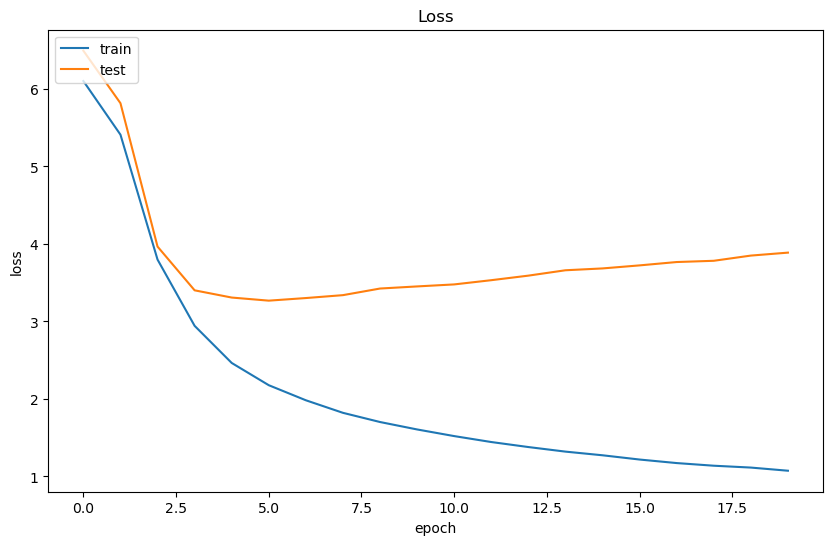

In [119]:
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Eval and Inference

In [120]:
acc = model.evaluate(tmp_x, preproc_english_sentences, verbose=0)
print("Train accurancy: ", acc[1])

Train accurancy:  0.7912973165512085


In [122]:
### Inference
tamil_data[10]

'பள்ளி மாணவர்கள் மற்றும் பல்கலைக்கழக மாணவர்கள் பிரான்ஸ் நெடுகிலும் நெடுஞ்சாலைகள் வீதிகள் ஆகியவற்றை தடுப்புக்களுக்கு உட்படுத்திய வகையில் நேற்று இன்னும் கூடுதலான கைதுகள் நிகழ்த்தப்பட்டன'

In [123]:
desc_trans = logits_to_text(model.predict(tmp_x[:100])[10], english_tokenizer)

4/4 [==============================] - 0s 36ms/step


In [131]:
desc_trans[:130]

'further arrests outlawing reported yesterday in high school in university students blockaded for at the disrupting traffic across '

In [135]:
tmp_x[:100][10]

array([2066,  337,    2,  985,  337,  183, 2067, 2068, 2069,  625, 2070,
       2071,   26,  338,   58,  263, 2072, 2073,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0])

### Test Data

In [148]:
tamil_sentence = ['பள்ளி மாணவர்கள் மற்றும் பல்கலைக்கழக மாணவர்கள் பிரான்ஸ் நெடுகிலும் நெடுஞ்சாலைகள் வீதிகள் ஆகியவற்றை தடுப்புக்களுக்கு உட்படுத்திய வகையில் நேற்று இன்னும் கூடுதலான கைதுகள் நிகழ்த்தப்பட்டன']

In [149]:
preprocess_x, x_tk = tokenize(tamil_sentence)

In [150]:
preprocess_x = pad(preprocess_x)

In [151]:
preprocess_x

array([[ 2,  1,  3,  4,  1,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
        16, 17]])

In [152]:
translation_logits = model.predict(preprocess_x)

1/1 [==============================] - 0s 17ms/step
